## Using pandas get_dummies approach.


In [12]:
%reload_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
import os
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from ccp.cca2 import CCA

In [2]:
NUM_PATH = f'{os.getcwd()}/data/G-Datasets/exp1_numdataset_101_data.tsv'
MIXED_PATH = f'{os.getcwd()}/data/G-Datasets/exp2_hetdataset_HL50_101_data.tsv'
CAT_PATH = f'{os.getcwd()}/data/G-Datasets/exp3_catdataset_101_data.tsv'

## G-bic synthetic data sets experiments
### Fully numerical dataset 

In [7]:
df1 = pd.read_csv(NUM_PATH, delimiter='\t').drop(['X'], axis=1)
data = df1.to_numpy()
print(f"Intital shape of the FULLY numerical set  {data.shape}")

Intital shape of the FULLY numerical set  (100, 60)


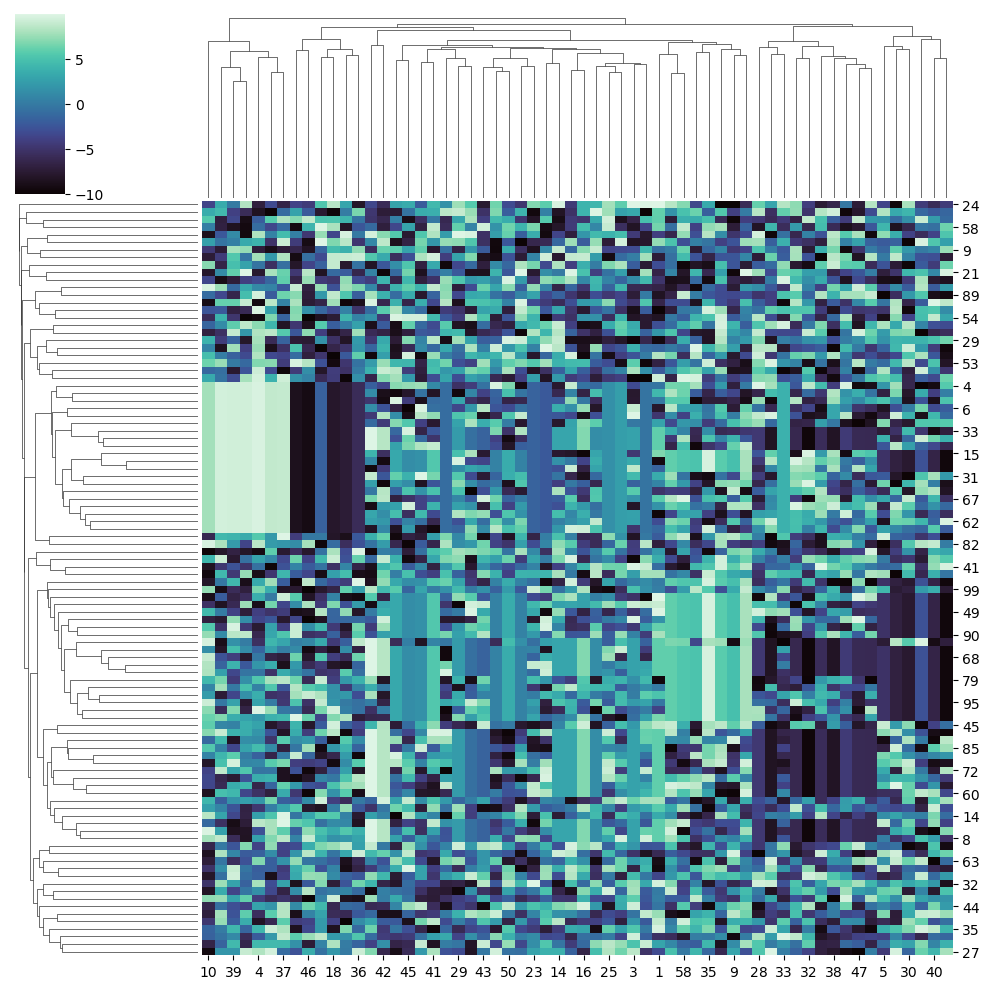

In [9]:
NB_GENES = 50
sns_plot = sns.clustermap(data, cmap="mako")
sns_plot.savefig(f"./figures/G-bic-numerical{NB_GENES}_heatmap.pdf")

In [72]:
alpha = 1.2
cc_algo = CCA(0, alpha, nb_biclusters=3, missingval_indicator=None, row_thr=10, col_thr=30)

# updating the sigma threshold
SIGMA = (cc_algo.msr_score(data, np.arange(data.shape[0]), np.arange(data.shape[1]))[0]) /2
print(SIGMA)
cc_algo.sigma = SIGMA


# running the biclustering algorithm on the mixed data set
cc_algo.run(data)


16.083170422992755


In [82]:
for b in cc_algo.biclusters:
    print(b.msr_score)
    print(len(b.rows),len(b.columns))

32.173770704328604
99 60
31.65369177083077
99 60
33.129477406059145
99 60


### Mixed synthetic dataset

In this section, the expected shape of the data after One-Hot encoding is the following (only for the attributes size): 
\begin{equation}
    columns = numerical\_attributes + (Nb\_categories * categorical\_attributes)
\end{equation}

In [5]:
df2 = pd.read_csv(MIXED_PATH, delimiter='\t').drop(['X'], axis=1)
categorical_subdf2 =  df2.select_dtypes(include='object')
numerical_subdf2 = df2.select_dtypes(include="float")
categories_df2 = categorical_subdf2.stack().unique()
nb_att2, nb_cat2, offset2 = categorical_subdf2.shape[1], categories_df2.shape[0], numerical_subdf2.shape[1]


print(f'Total number of categories : {nb_cat2}')
print(f"N° categorical elements = {nb_att2}\nN° numerical attributes {offset2}")


Total number of categories : 5
N° categorical elements = 30
N° numerical attributes 30


In [6]:
## performing one-hot encoding
transformed_df2 = pd.get_dummies(categorical_subdf2)
augmented_df2 = pd.concat([numerical_subdf2, transformed_df2], axis=1).to_numpy()

#### Reverse engineering the attributes : going from encoded categories to original ones
Given a bicluster with a set of rows and columns, we would want to go from the encoded rows and columns indecies, to the actual indices refering to the initial categories in the data set. So for example : 
`b1_transformedrows = [0,1,,20,4,5,8,6,]` to `b1rows = [0,1,2,5]`

In [8]:
b1cols = np.array([0,1,2,5,7,4,6,8,97,171,173,174,165,162,152,])
b1rows = np.array([0,10,88,74,12,13,5,8,46,75,14,1])
offset = numerical_subdf2.shape[1]

def reconstruct_bicluster(rows, t_columns,nb_cat,nb_att, offset : int):

    # order the columns and the rows
    rows = np.sort(rows,)
    t_columns = np.sort(t_columns)

    # find only the categorical columns by removing the offset
    num_cols = t_columns[np.where(t_columns < offset)[0]]
    cat_cols = np.sort(t_columns[np.where(t_columns > offset)[0]])
    codes_map = np.arange(offset, offset + (nb_cat * nb_att)).reshape(nb_att,nb_cat)
    
    positions, _ = np.where(np.isin(codes_map, cat_cols))

    decoded_columns = np.concatenate((num_cols, np.unique(positions) + offset))

    # print(decoded_columns)
    # print(categories_df2[category_argvalues])
    # print(df2.iloc[rows, decoded_columns])


    return rows, decoded_columns


In this section, we will experiment with the `CCP algorithm` on the transformed data set.

In [51]:
alpha = 1.2
cc_algo = CCA(0, alpha, nb_biclusters=3, missingval_indicator=None)

# updating the sigma threshold
SIGMA = cc_algo.msr_score(augmented_df2, np.arange(augmented_df2.shape[0]), np.arange(augmented_df2.shape[1]))[0] /2
cc_algo.sigma = SIGMA


# running the biclustering algorithm on the mixed data set
cc_algo.run(augmented_df2)

17.388125997480127
Bicluster 1
33.408650078535466
Bicluster 2
31.757219974585603
Bicluster 3
33.21317887413935


In [52]:
for idx,b in enumerate(cc_algo.biclusters):
    _, bcols_reconstructed = reconstruct_bicluster(b.rows, b.columns, nb_cat2, nb_att2, offset2)
    print(f"bicluster {idx+1} MSR = {b.msr_score} of shape ({b.rows.shape[0]}, {bcols_reconstructed.shape[0]})")

bicluster 1 MSR = 33.36434090829207 of shape (83, 52)
bicluster 2 MSR = 33.37167670811997 of shape (77, 52)
bicluster 3 MSR = 33.531211751852396 of shape (81, 53)


### Fully categorical set

In [62]:
df3 = pd.read_csv(CAT_PATH, delimiter='\t').drop(['X'], axis=1)
categorical_subdf3=  df3.select_dtypes(include='object')
categories_df3 = categorical_subdf3.stack().unique()
numerical_subdf3 = df3.select_dtypes(include='float')
nb_att3, nb_cat3, offset3 = categorical_subdf3.shape[1], categories_df3.shape[0], numerical_subdf3.shape[1]
print(f"Intital shape of the FULLY categorical set {df3.shape}")

Intital shape of the FULLY categorical set (100, 60)


In [8]:
transformed_df3 = pd.get_dummies(categorical_subdf3)
data3 = transformed_df3.to_numpy(dtype=int)


NameError: name 'categorical_subdf3' is not defined

In [82]:
alpha = 1.2
cc_algo3 = CCA(0, alpha, nb_biclusters=3, missingval_indicator=None)

# updating the sigma threshold
SIGMA = cc_algo3.msr_score(data3, np.arange(data3.shape[0]), np.arange(data3.shape[1]))[0] /2
cc_algo3.sigma = SIGMA


# running the biclustering algorithm on the mixed data set
cc_algo3.run(data3)


Bicluster 1
0.0
Bicluster 2
0.0
Bicluster 3
0.0


In [83]:
for idx,b in enumerate(cc_algo3.biclusters):
    _, bcols_reconstructed = reconstruct_bicluster(b.rows, b.columns, nb_cat2, nb_att2, offset2)
    print(f"bicluster {idx+1} MSR = {b.msr_score} of shape ({b.rows.shape[0]}, {bcols_reconstructed.shape[0]})")

bicluster 1 MSR = 0.0 of shape (22, 39)
bicluster 2 MSR = 0.0 of shape (22, 39)
bicluster 3 MSR = 0.0 of shape (22, 39)


## Comparing with benchmark data 

In [ ]:
gbic_numerical